<a href="https://colab.research.google.com/github/LeeJaeEun0/230102_mini_project/blob/main/230113_05_DL_07_2_%EC%9E%8E%EC%82%AC%EA%B7%80_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이스라인 모델

##환경 설정

In [ ]:
import torch
import random
import numpy as np
import os

# 시드값
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed) # 파이썬 난수 생성기 시드 고정
np.random.seed(seed) # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (cpu)
torch.cuda.manual_seed(seed) # 파이토치 난수 생성기 시드 고정 (gpu)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티 gpu)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False # cudnn 사용 해제

In [ ]:
# GPU 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 데이터 준비

In [ ]:
from google.colab import files
files.upload()
# kaggle > Profile 이미지 > Account > Account > API > Create New API Token
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# late submission
# https://www.kaggle.com/competitions/plant-pathology-2020-fgvc7
!kaggle competitions download -c plant-pathology-2020-fgvc7 # kaggle.json? -> 403, late submission -> 401

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
 98% 767M/779M [00:10<00:00, 152MB/s]
100% 779M/779M [00:10<00:00, 79.4MB/s]


In [ ]:
!unzip plant-pathology-2020-fgvc7

Archive:  plant-pathology-2020-fgvc7.zip
  inflating: images/Test_0.jpg       
  inflating: images/Test_1.jpg       
  inflating: images/Test_10.jpg      
  inflating: images/Test_100.jpg     
  inflating: images/Test_1000.jpg    
  inflating: images/Test_1001.jpg    
  inflating: images/Test_1002.jpg    
  inflating: images/Test_1003.jpg    
  inflating: images/Test_1004.jpg    
  inflating: images/Test_1005.jpg    
  inflating: images/Test_1006.jpg    
  inflating: images/Test_1007.jpg    
  inflating: images/Test_1008.jpg    
  inflating: images/Test_1009.jpg    
  inflating: images/Test_101.jpg     
  inflating: images/Test_1010.jpg    
  inflating: images/Test_1011.jpg    
  inflating: images/Test_1012.jpg    
  inflating: images/Test_1013.jpg    
  inflating: images/Test_1014.jpg    
  inflating: images/Test_1015.jpg    
  inflating: images/Test_1016.jpg    
  inflating: images/Test_1017.jpg    
  inflating: images/Test_1018.jpg    
  inflating: images/Test_1019.jpg    
  inflati

In [ ]:
import pandas as pd

# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')
# submission = pd.read_csv('sample_submission.csv')

# 데이터 경로 (Kaggle 대응)
data_path = './'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### 훈련 데이터, 검증 데이터 분리

In [ ]:
train.columns.tolist()[1:]

['healthy', 'multiple_diseases', 'rust', 'scab']

In [ ]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,
                                test_size=0.1,
                                stratify=train[
                                    train.columns.tolist()[1:]
                                    ], # 훈련셋/검증셋을 라벨 비중에 따라 배분
                                random_state=50)

In [ ]:
print(f'훈련 데이터 개수 : {len(train)}')
print(f'검증 데이터 개수 : {len(valid)}')

훈련 데이터 개수 : 1638
검증 데이터 개수 : 183


In [ ]:
def show_stratified(df):
    healthy = df.loc[df['healthy']==1]
    multiple_diseases = df.loc[df['multiple_diseases']==1]
    rust = df.loc[df['rust']==1]
    scab = df.loc[df['scab']==1]
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rc('font', size=15)
    plt.figure(figsize=(7, 7))
    # label = train.columns.tolist()[1:]
    label = ['healthy', 'multiple_diseases', 'rust', 'scab']
    # 타깃값 분포 파이 그래프
    plt.pie(
        [len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels = label,
        autopct = '%.1f%%' # 소수점 1째자리까지
    )
    plt.show()

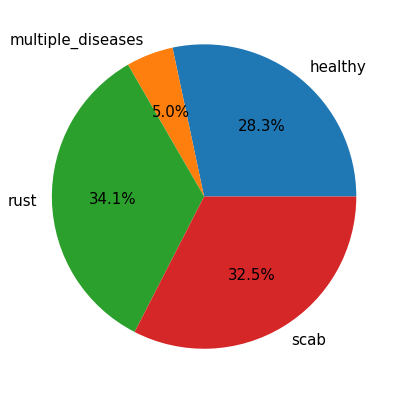

In [ ]:
show_stratified(train)

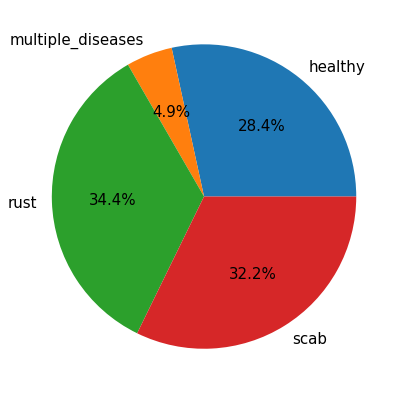

In [ ]:
show_stratified(valid)

## 데이터셋 클래스

In [ ]:
from torch.utils.data import Dataset
import cv2

class ImageDataset(Dataset):
    # 초기화 메소드(생성자)
    def __init__(self,
                 df,
                 img_dir = './',
                 transform = None,
                 is_test=False, # **
                 # 데이터셋을 훈련용 또는 검증용 : False
                 # -> 라벨을 같이 반환
                 # 테스트용으로 만들 거면 : True
                 # -> 이미지만 반환
                 ):
        super().__init__()
        
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test # **
    
    # 데이터셋 크기 반환 메소드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메소드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0] # 이미지 ID (이미지 파일 이름)
        img_path = self.img_dir + img_id + '.jpg' # 이미지 파일의 전체 경로
        # ** '.jpg'가 원본에 없기 때문에 확장자 추가
        image = cv2.imread(img_path) # 이미지 파일 읽기
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 (cv2 -> plt)
        # 기본 변환기 쓸 때
        # if self.transform is not None:
        #     image = self.transform(image) # 변환기(transform)가 있다면 이미지 변환
        # ** albumentations 변환기
        if self.transform is not None:
            image = self.transform(image=image)['image']
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 (이미지랑) 타깃값도 반환
        if self.is_test:
            return image # 테스트용일 때 이미지만.
        # 타깃값 4개 중 가장 큰 값의 인덱스 -> 1, 0, 0, 0 => 0번째
        label = np.argmax(self.df.iloc[idx, 1:5]) # 원핫인코딩 -> 라벨인코딩 (0~3)
        return image, label # 훈련/검증용일 때 이미지 & 라벨(타깃값)을 모두 리턴

### 이미지 변환기 정의

In [ ]:
# https://albumentations.ai/docs/
# https://gaussian37.github.io/dl-pytorch-albumentation/
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(450, 650),       # 이미지 크기 조절
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절 (<- 랜덤으로 밝기 비율 조정)
                               contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1),   # 양각화(튀어나오게), 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)], p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환 -> 이동, 확대/축소, 회전 => 이미지 모양을 전체적으로 바꾸는 변환기
    A.Normalize(),            # 정규화 변환 
    ToTensorV2()              # 텐서로 변환(파이토치가 이해할 수 있는 형태)
])



In [ ]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절 
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

## 데이터셋 생성

In [ ]:
# img_dir = '/kaggle/input/plant-pathology-2020-fgvc7/images/'
img_dir = 'images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

### 데이터로더 생성

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, 
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)# 빠른 학습을 위한 멀티 프로세싱 적용
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, 
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

* (이전까지) 계층(레이어)별 구성 -> 스스로 만들었음
* (이번에는) 사전 훈련된 모델을 전이 학습시키는 것

**사전 훈련 모델** : 이미 한 분야에서 훈련을 마친 모델
**전이 학습** : 사전 훈련 모델을 유사한 다른 영역에서 재훈련시키는 기법

**파이토치에서 사전 훈련 모델을 이용하는 방법**
1. torchvision.models 모듈 이용
* https://pytorch.org/vision/stable/models.html
* 제공하는 모델이 많지 않음
* 기본적으로 설치되어 있기 때문에 사용하기 간단
2. pretrainedmodels 모듈 이용
* https://github.com/Cadene/pretrained-models.pytorch
* 테슬라에서 자율주행 연구하는 연구자
3. 직접 구현한 모듈 이용
* 1, 2에는 없는 모델을 사용하고 싶다면? 찾아야 함
* 구글 -> '{원하는 사전 훈련 모델} + github pytorch'

## EfficientNet 모델 생성
* 2019년 5월, CNN

In [ ]:
!pip show efficientnet-pytorch
!pip install efficientnet-pytorch==0.7.1 -q

  Preparing metadata (setup.py) ... done


In [ ]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [ ]:
# 방법2
# 출력값 직접 설정
model = EfficientNet.from_pretrained('efficientnet-b7')

# 전결합 계층 -> 마지막 분류할 때 몇개로 분류할지
model._fc = nn.Sequential( # EfficientNet의 원본이 학습했던 전결합계층의 I/O features
    nn.Linear(model._fc.in_features, model._fc.out_features), # 2560 -> 1000
    nn.ReLU(), # 활성화 함수
    nn.Dropout(p=0.5), # 50%
    nn.Linear(model._fc.out_features, 4) # 1000 -> 4
 )

In [ ]:
# 사전 훈련된 efficientnet-b7 모델 불러오기
model = EfficientNet.from_pretrained('efficientnet-b7', num_classes=4) # 4가지로 분류
#num)_class: 출력값의 개수
# 가중치, 특징맵 만드는 레이어들의 정보 가져와서 -> 우리 사정에 맞게 튜닝

model = model.to(device) # 장비 할당

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7


## 모델 훈련

In [ ]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

In [ ]:
# 옵티마이저 : Adam -> AdamW : Adam + 가중치 감쇠 추가로 적용
# 가중치 감쇠 weight decay : 가중치를 작게 조절하는 규제 기법으로, 과적합(과대적합)을 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [ ]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대 

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # == [ 훈련 ] ==============================================
    model.train()        # 모델을 훈련 상태로 설정 
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
    
    # '반복 횟수'만큼 반복 
    for images, labels in tqdm(loader_train):
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item() 
        loss.backward() # 역전파 수행
        optimizer.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
    
    # == [ 검증 ] ==============================================
    model.eval()          # 모델을 평가 상태로 설정 
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화 
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화 
    
    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(4)[labels.cpu()].cpu().numpy()  
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력 
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [1/5] - 훈련 데이터 손실값 : 0.6920
에폭 [1/5] - 검증 데이터 손실값 : 0.2763 / 검증 데이터 ROC AUC : 0.9500


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [2/5] - 훈련 데이터 손실값 : 0.3458
에폭 [2/5] - 검증 데이터 손실값 : 0.2030 / 검증 데이터 ROC AUC : 0.9668


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [3/5] - 훈련 데이터 손실값 : 0.2492
에폭 [3/5] - 검증 데이터 손실값 : 0.1701 / 검증 데이터 ROC AUC : 0.9686


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [4/5] - 훈련 데이터 손실값 : 0.1633
에폭 [4/5] - 검증 데이터 손실값 : 0.3139 / 검증 데이터 ROC AUC : 0.9715


  0%|          | 0/410 [00:00<?, ?it/s]

에폭 [5/5] - 훈련 데이터 손실값 : 0.1301
에폭 [5/5] - 검증 데이터 손실값 : 0.1441 / 검증 데이터 ROC AUC : 0.9900


In [ ]:
!ls drive/MyDrive/'Colab Notebooks'

In [ ]:
!pwd

/content


In [ ]:
# 구글 드라이브 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/plant_model1.pt")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 예측 및 결과 제출

In [ ]:
# 테스트용 데이터셋, 데이터 로더 생성
dataset_test = ImageDataset(
    test, img_dir=img_dir, transform=transform_test, is_test=True)
loader_test=DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False,
    worker_init_fn=seed_worker, generator=g, num_workers=2 #병렬 프로세싱 위한 코드
)

In [ ]:
# 예측
model.eval() # 평가 모드

preds = np.zeros((len(test), 4)) # 테스트 데이터셋만큼의 길이를 가지는 4열짜리 행렬 (0을 가득찬)
# preds -> 예측값 저장용 배열

with torch.no_grad(): # 테스트용이므로 기울기 계산 X
    for i, images in enumerate(loader_test): # 테스트용 데이터 로더의 각각 인덱스와 값을 받음
        images = images.to(device)
        outputs = model(images) # 모델을 거친 예측 결과
        # 타깃을 예측한 확률
        print(outputs.cpu())
        print(torch.softmax(outputs.cpu(), dim=1))
        print(torch.softmax(outputs.cpu(), dim=1).squeeze())
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        # outputs -> 신경망의 출력값이 배치 크기만큼 존재
        # -> 소프트맥스 함수 -> 확률값 (0~1) -> preds_part
        preds[i*batch_size:(i+1)*batch_size] += preds_part # preds 배열에, 배치 사이즈만큼 계산된 값을, 인덱스에 맞게 집어넣어줌

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [1.4290e-06, 8.7835e-03, 9.8944e-01, 1.7710e-03]])
tensor([[3.3060e-03, 1.3051e-01, 8.6075e-01, 5.4373e-03],
        [1.3264e-03, 1.1808e-03, 8.0633e-05, 9.9741e-01],
        [1.2569e-03, 4.0630e-01, 5.8958e-01, 2.8636e-03],
        [1.4290e-06, 8.7835e-03, 9.8944e-01, 1.7710e-03]])
tensor([[-1.9767, -0.6971, -2.3549,  4.7427],
        [ 4.5462, -1.4010,  1.4405, -4.7553],
        [-1.4777, -1.8187, -3.2416,  6.0757],
        [-2.7275, -0.3545,  7.2155, -4.5822]])
tensor([[1.1997e-03, 4.3130e-03, 8.2186e-04, 9.9367e-01],
        [9.5465e-01, 2.4946e-03, 4.2765e-02, 8.7154e-05],
        [5.2381e-04, 3.7247e-04, 8.9771e-05, 9.9901e-01],
        [4.8036e-05, 5.1541e-04, 9.9943e-01, 7.5172e-06]])
tensor([[1.1997e-03, 4.3130e-03, 8.2186e-04, 9.9367e-01],
        [9.5465e-01, 2.4946e-03, 4.2765e-02, 8.7154e-05],
        [5.2381e-04, 3.7247e-04, 8.9771e-05, 9.9901e-01],
        [4.8036e-05, 5.1541e-04, 9.9943e-01, 7.5172e-06]])
tensor([[ 6.7445, -2.

In [ ]:
# 이미지 ID를 제외한 컬럼들 조회
submission[submission.columns[1:]]
# 예측값을 해당 id에 맞게 집어넣어주는 코드
submission[submission.columns[1:]] = preds

In [ ]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.003067e-04,0.004988,0.994244,0.000668
1,Test_1,1.052493e-06,0.000732,0.997327,0.001940
2,Test_2,1.667870e-03,0.005427,0.000561,0.992344
3,Test_3,9.999107e-01,0.000007,0.000017,0.000065
4,Test_4,9.029832e-07,0.000267,0.999108,0.000623


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>